In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import notebook_libs.utilities as util
import notebook_libs.prometheus as prom

2023-02-14_2-replicas
count    49992.000000
mean       946.597369
std        278.055201
min        387.418985
25%        776.705563
50%        904.858708
75%       1164.743125
max       2285.207987
Name: client_latency_ms, dtype: float64

2023-02-14_3-replicas
count    65387.000000
mean       798.717425
std        332.514299
min        382.134914
25%        520.700574
50%        767.688990
75%        943.928003
max       2754.462004
Name: client_latency_ms, dtype: float64

2023-02-13_4-replicas
count    23178.000000
mean       558.099026
std        180.674288
min        382.857800
25%        416.267276
50%        482.612491
75%        700.830102
max       1781.734943
Name: client_latency_ms, dtype: float64

2023-02-13_5-replicas
count    60000.000000
mean       529.247941
std        168.207449
min        382.488966
25%        408.629835
50%        445.486307
75%        597.952604
max       1953.076124
Name: client_latency_ms, dtype: float64



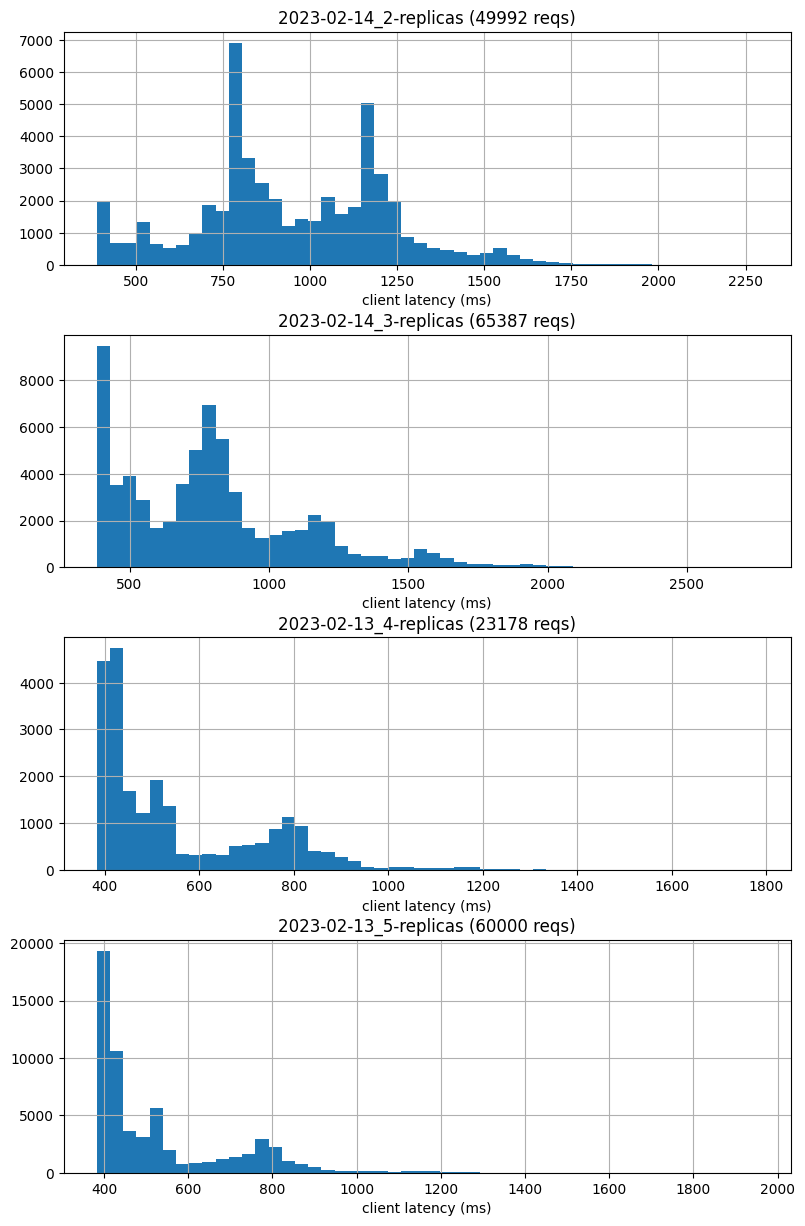

In [2]:
util.compare_client_latency_distributions()

in-progress
count      48.000000
mean      587.410763
std       155.475458
min       507.328987
25%       523.164570
50%       536.316514
75%       556.089938
max      1205.536127
Name: client_latency_ms, dtype: float64



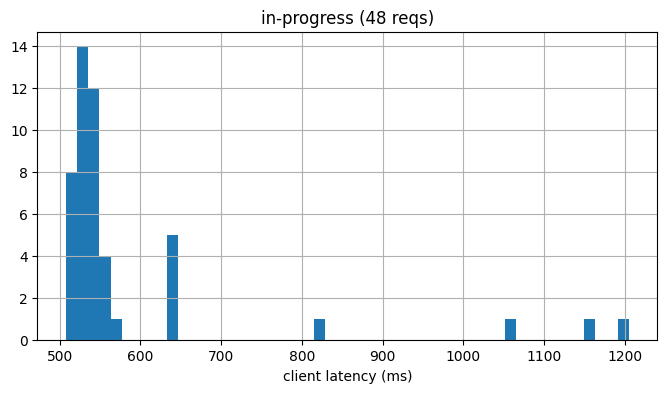

In [9]:
df = util.read_client_requests_in_progress()
f, ax = plt.subplots(figsize=[8,4])
util.plot_client_latency_distribution(df, "in-progress", ax)

In [14]:
df_client, first_request_time, final_request_time = util.read_client_requests(util.experiments[1])
print(first_request_time, final_request_time)

1676335489.4094336 1676345875.0449326


In [15]:
df_client.describe()

,client_latency_ms,response_start_time_sec,response_function_latency_ms,response_memory_request,response_memory_usage_mb,response_sleep_delay_ms,response_load_time_ms,response_load_request,response_load_calibration
count,65387.000000,6.538700e+04,65387.000000,65387.0,65387.000000,65387.0,65387.000000,65387.0,65387.0
mean,798.717425,1.676341e+09,386.764006,150.0,193.748764,200.0,12.247214,6.0,15000.0
std,332.514299,3.011386e+03,31.270478,0.0,0.094019,0.0,2.048029,0.0,0.0
min,382.134914,1.676335e+09,364.354849,150.0,193.660156,200.0,10.720968,6.0,15000.0
25%,520.700574,1.676338e+09,374.044180,150.0,193.660156,200.0,11.153460,6.0,15000.0
50%,767.688990,1.676341e+09,382.170916,150.0,193.707031,200.0,11.417627,6.0,15000.0
75%,943.928003,1.676343e+09,391.300201,150.0,193.878906,200.0,13.587236,6.0,15000.0
max,2754.462004,1.676346e+09,1307.286501,150.0,193.878906,200.0,115.598917,6.0,15000.0


<AxesSubplot: title={'center': 'Requests/Minute'}, xlabel='bucket_1_min'>

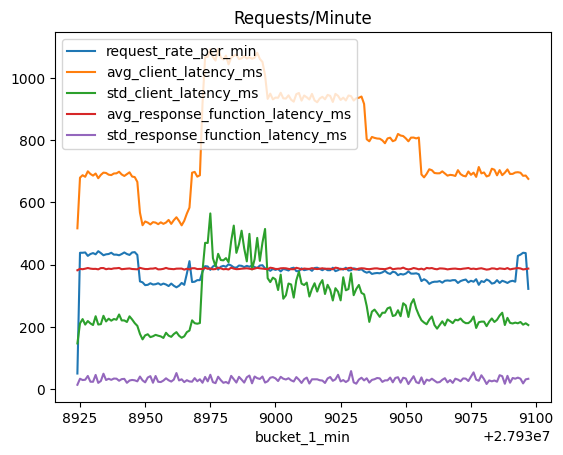

In [6]:
df, first_request_time, final_request_time = util.read_client_requests(util.experiments[1])
df_bucket = util.create_1_min_bucket_client_metrics(df)
df_bucket.plot(x='bucket_1_min', y=[
    "request_rate_per_min", 
    "avg_client_latency_ms",
    "std_client_latency_ms",
#    "avg_response_load_time_ms",
#    "std_response_load_time_ms"
    "avg_response_function_latency_ms",
    "std_response_function_latency_ms"
]
,layout=[5,1] 
,title="Requests/Minute")

## Prometheus Data

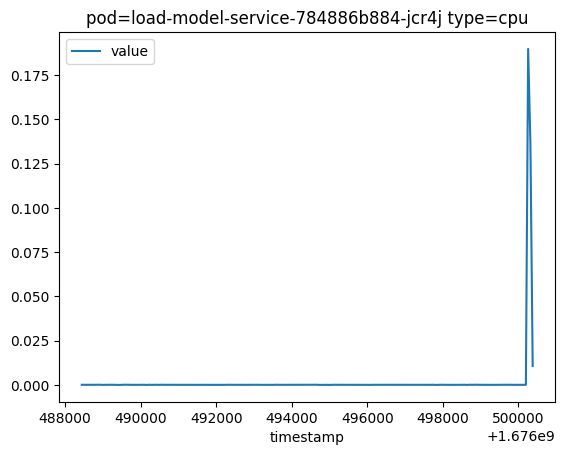

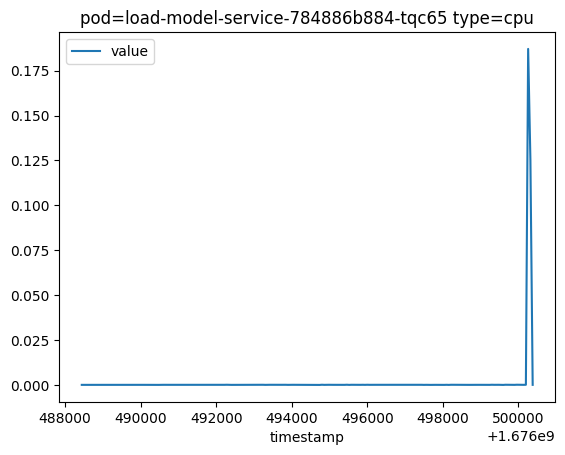

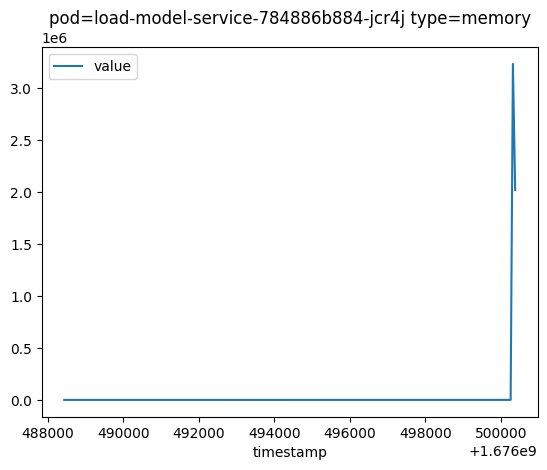

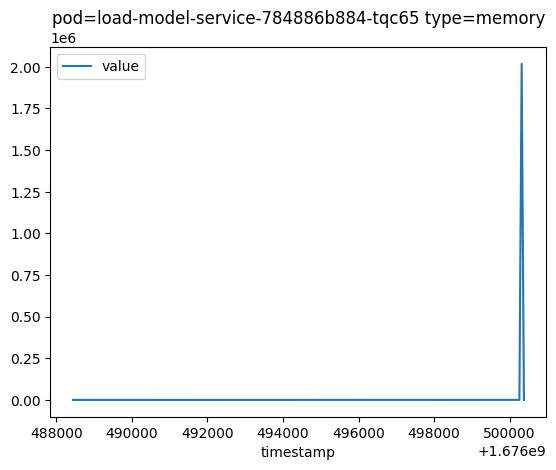

In [10]:
result = prom.fetch_experiment_pod_data()
util.plot_pod_metrics(result)

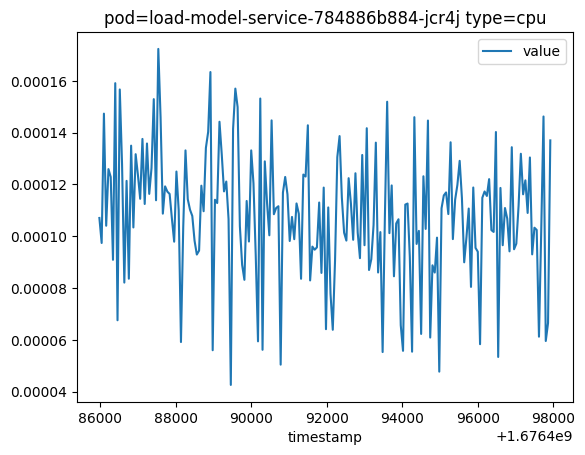

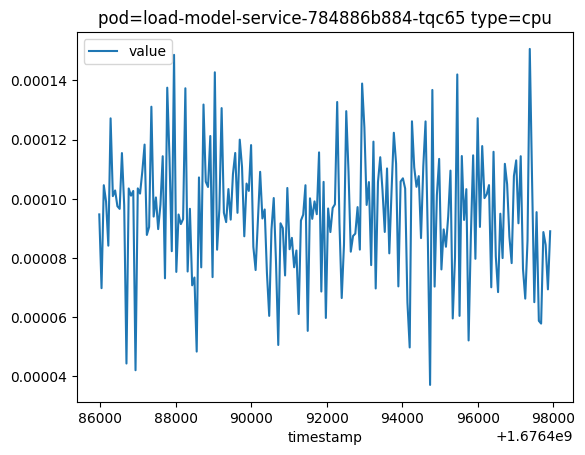

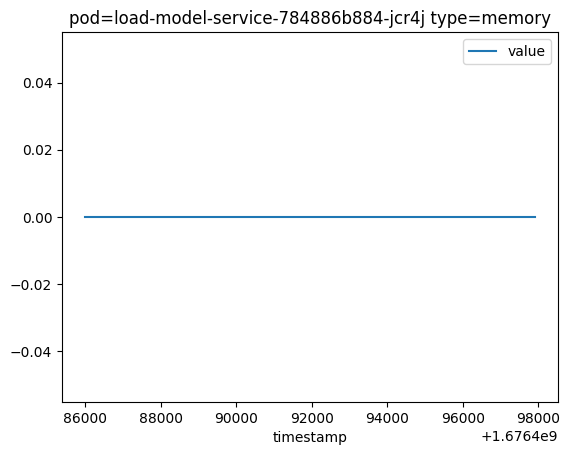

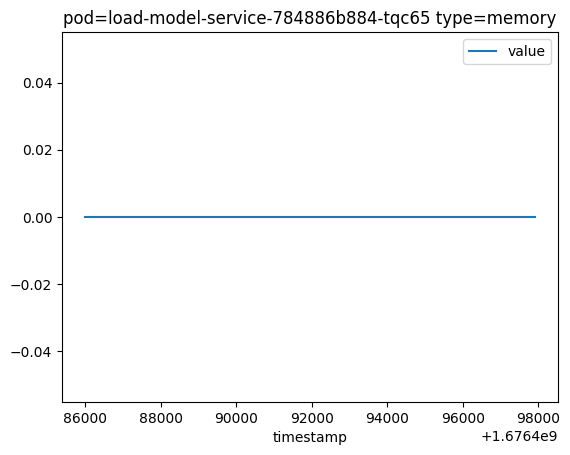

In [4]:
util.persist_pod_dfs(result, "tmp")

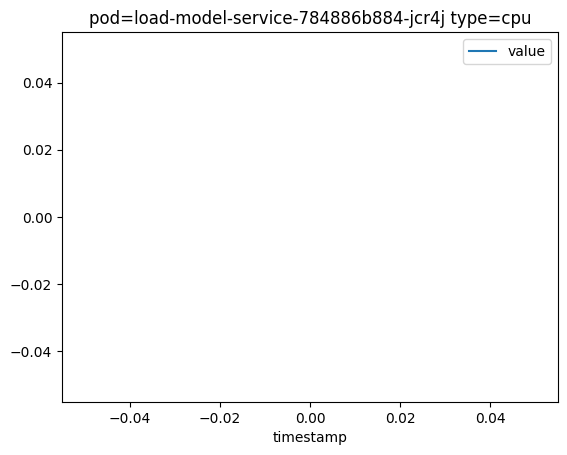

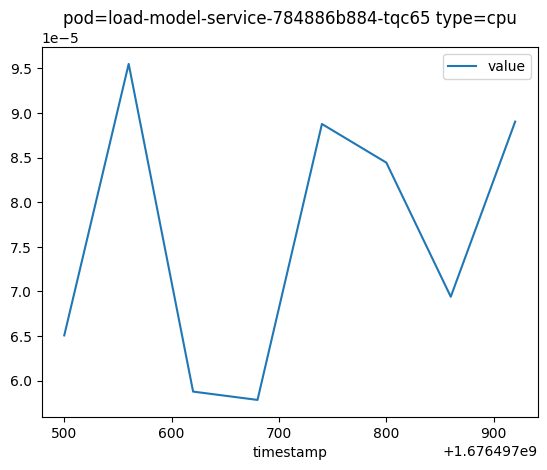

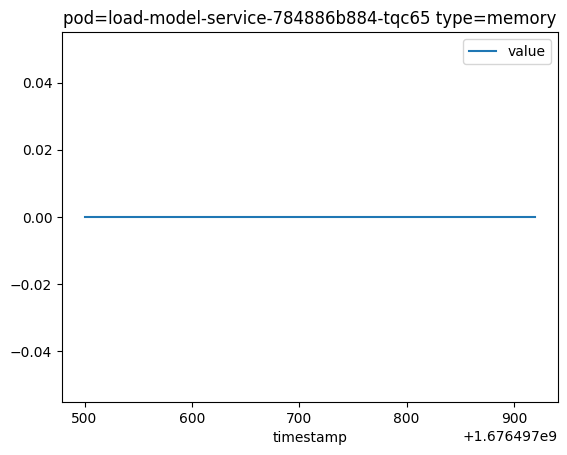

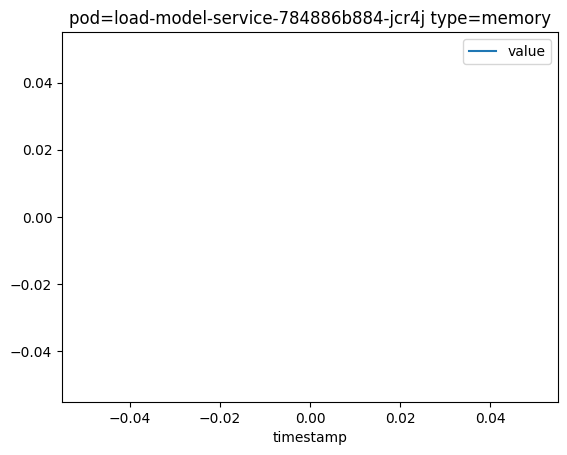

In [8]:
result = util.read_pod_df_list("tmp", 1676497458,1676497958 )
util.plot_pod_metrics(result)

### To Do
* match windows
* transaction rate and a metric of client loading
* correlations between client and server metrics
* what parameters to scan with more tests?
* how long is 10K transactions?
* add request failure counts to client

load-model-service-784886b884-jcr4j


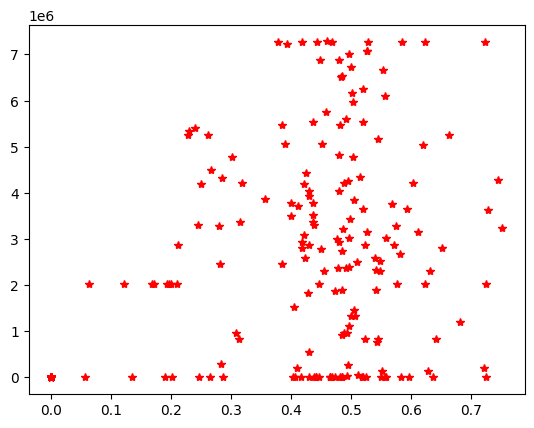

In [17]:
key = list(dfs_cpu.keys())[1]
print(key)
plt.plot(dfs_cpu[key].value.values, dfs_mem[key].value.values, "r*")